In [1]:
import os
import sys
sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

# os.chdir(current_dir_path + '\\ultils')
os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *

os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
# os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

/Users/wangqiqian/Desktop/TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [3]:
select_lst = [
    '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱',
    '事故位置大類別名稱', '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
    '事故類型及型態子類別名稱', '死亡受傷人數',
    # '經度', '緯度'
]
print(len(select_lst))

def preprocess(input_data, select_lst):
    
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 3]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)
# Concat
rbind_data = pd.concat([dist_dfA1, dist_dfA2], axis=0, ignore_index=True)
assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print(dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

22
(65306, 185)


### PCA也可以使用，只是會導致解釋上有問題

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
lens = pca.fit_transform(mapper_numpy)

# 查看每個主成分保留的變異量比例
explained_variance_ratio  = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
print(cumulative_variance_ratio)
print(sum(explained_variance_ratio))
print(explained_variance_ratio)

[0.22919947 0.34388027 0.41060919]
0.410609193362854
[0.22919947 0.1146808  0.06672892]


In [ ]:
# import plotly.express as px

# df = pd.DataFrame(lens, columns=['PC1', 'PC2', 'PC3'])
# fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', title="PCA 3D Scatter Plot")
# fig.show()

### Multiple correspondence analysis (MCA)
多重對應分析是專門針對dummy來進行降維的，所以使用它作為主要方法沒有問題

In [5]:
import prince

# The input of MCA no need to use dummy_data
MCA_X = rbind_data.drop(['死亡', '受傷'], axis=1)

mca = prince.MCA(
    one_hot=True,
    n_components=6,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)

mca.fit(MCA_X)
lens = mca.transform(MCA_X)

print(mca.eigenvalues_summary)
# mca.column_contributions_.head().style.format('{:.0%}')

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.256         3.32%                      3.32%
1              0.163         2.11%                      5.42%
2              0.141         1.82%                      7.25%
3              0.127         1.65%                      8.90%
4              0.108         1.40%                     10.29%
5              0.103         1.34%                     11.63%


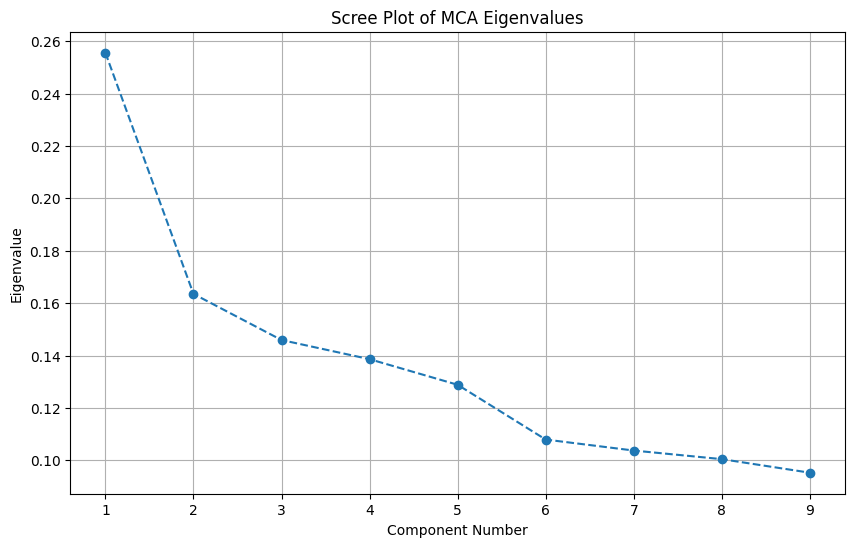

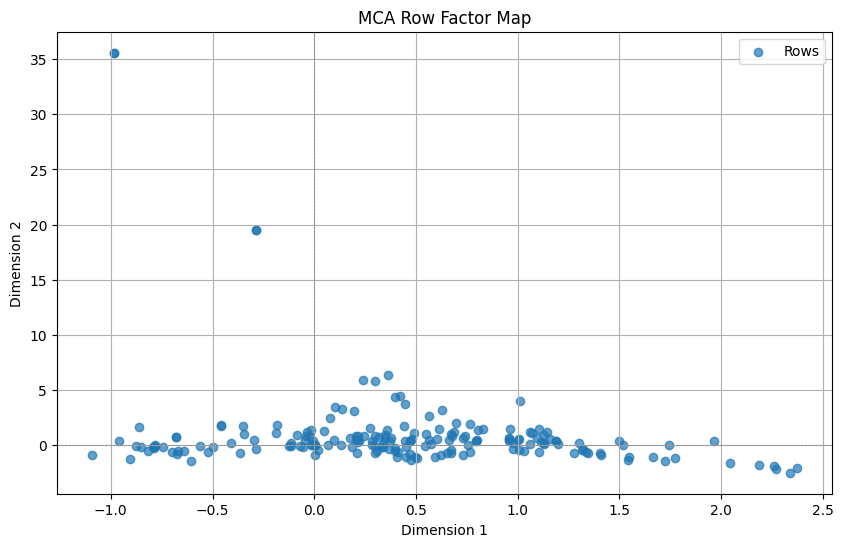

In [38]:
import matplotlib.pyplot as plt

# Generate the scree plot for MCA eigenvalues
eigenvalues = mca.eigenvalues_

# Plot the eigenvalues to show the variance explained by each component
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='--')
plt.title("Scree Plot of MCA Eigenvalues")
plt.xlabel("Component Number")
plt.ylabel("Eigenvalue")
plt.xticks(range(1, len(eigenvalues) + 1))
plt.grid(True)
plt.show()

# Generate MCA row/column factor map
# coordinates = mca.row_coordinates(MCA_X)
coordinates = mca.column_coordinates(MCA_X)
plt.figure(figsize=(10, 6))
plt.scatter(coordinates[0], coordinates[1], alpha=0.7, label="Rows")

# Label the plot
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.title("MCA Row Factor Map")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.legend()
plt.show()

# Find the best mapper

Best interval for overlap=3: 9
Best interval for overlap=4: 7
Best interval for overlap=5: 8

In [ ]:
detailed_results = []

for overlap in range(3, 6):
    silhouette_for_intervals = []

    for interval in range(5, 11):
        mapper_algo = MapperAlgorithm(
            cover=CubicalCover(
                n_intervals=interval,
                overlap_frac=overlap / 10
            ),
            clustering=AgglomerativeClustering(linkage='single')
        )

        mapper_info = mapper_algo.fit_transform(mapper_numpy, lens)
        silhouette_for_intervals.append(mapper_info[1])

        detailed_results.append({
            "overlap": overlap,
            "interval": interval,
            "silhouette": mapper_info[1],
            "mapper_info": mapper_info
        })
 
    best_interval = np.argmax(silhouette_for_intervals) + 5  # +5 因為 interval 從5開始

    print(silhouette_for_intervals)
    print(f"Best interval for overlap={overlap}: {best_interval}")

In [55]:
# detailed_results_df = pd.DataFrame(detailed_results)
# detailed_results_df.to_csv("/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid.csv", index=False)

output_file = '/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(detailed_results_df, f)

print(f"Results saved to {output_file}")

Results saved to /Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid.pkl


In [57]:
with open('/Users/wangqiqian/Desktop/TrafficTDApython/Version3/GridSearch/full_grid.pkl', 'rb') as f:
    loaded_df = pickle.load(f)

loaded_df

,overlap,interval,silhouette,mapper_info
0,3,5,0.165133,"((1, 3, 7, 10, 21, 22, 46, 64, 66, 75, 134, 13..."
1,3,6,0.176240,"((0, 25, 3, 53, 4, 8, 7, 10, 155, 9, 18, 22, 2..."
2,3,7,0.170927,"((0, 24, 2, 189, 4, 14, 31, 33, 311, 6, 325, 3..."
3,3,8,0.172061,"((0, 30, 79, 153, 2, 4, 14, 6, 399, 109, 8, 24..."
4,3,9,0.173917,"((0, 127, 432, 3, 26, 41, 59, 216, 575, 4, 110..."
5,3,10,0.167146,"((0, 2, 17, 27, 45, 129, 185, 232, 234, 379, 5..."
6,4,5,0.168361,"((1, 90, 92, 3, 6, 8, 15, 58, 69, 99, 115, 4, ..."
7,4,6,0.173738,"((1, 122, 2, 42, 52, 4, 36, 64, 7, 14, 17, 22,..."
8,4,7,0.174246,"((1, 23, 3, 263, 4, 16, 28, 32, 134, 6, 8, 33,..."
9,4,8,0.174476,"((0, 69, 205, 239, 2, 10, 27, 48, 175, 218, 4,..."


In [8]:
import pickle

overlap_to_intervals = {
    3: 9,
    4: 7,
    5: 8
}

results = {}

for overlap, interval in overlap_to_intervals.items():
    print(f"Processing overlap={overlap}, interval={interval}...")
    start_time = time.time()

    # 設定 MapperAlgorithm
    mapper_algo = MapperAlgorithm(
        cover=CubicalCover(
            n_intervals=interval,
            overlap_frac=overlap / 10  # 假設 overlap 是小數百分比的表示
        ),
        clustering=FailSafeClustering(
            clustering=AgglomerativeClustering(),
            verbose=True
        )
    )

    # 運行算法
    mapper_graph = mapper_algo.fit_transform(mapper_numpy, lens)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time for overlap={overlap}, interval={interval}: {elapsed_time:.2f} seconds")
    
    # 儲存結果
    results[(overlap, interval)] = mapper_graph

Processing overlap=3, interval=9...


11/25/2024 05:00:31 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/25/2024 05:00:32 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/25/2024 05:00:32 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/25/2024 05:01:03 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/25/2024 05:01:05 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/25/2024 05:01:24 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters

Elapsed time for overlap=3, interval=9: 371.88 seconds
Processing overlap=4, interval=7...


11/25/2024 05:10:41 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/25/2024 05:11:01 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/25/2024 05:11:01 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/25/2024 05:11:43 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/25/2024 05:11:43 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/25/2024 05:11:43 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters

Elapsed time for overlap=4, interval=7: 732.53 seconds
Processing overlap=5, interval=8...


11/25/2024 05:21:10 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/25/2024 05:21:10 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/25/2024 05:21:30 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/25/2024 05:21:41 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/25/2024 05:21:44 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/25/2024 05:21:44 PM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters

Elapsed time for overlap=5, interval=8: 469.82 seconds


In [9]:
# output_file = 'Version3/MapperGraphs/best_param.pkl'
# with open(output_file, 'wb') as f:
#     pickle.dump(results, f)

# print(f"Results saved to {output_file}")

Results saved to Version3/MapperGraphs/best_param.pkl


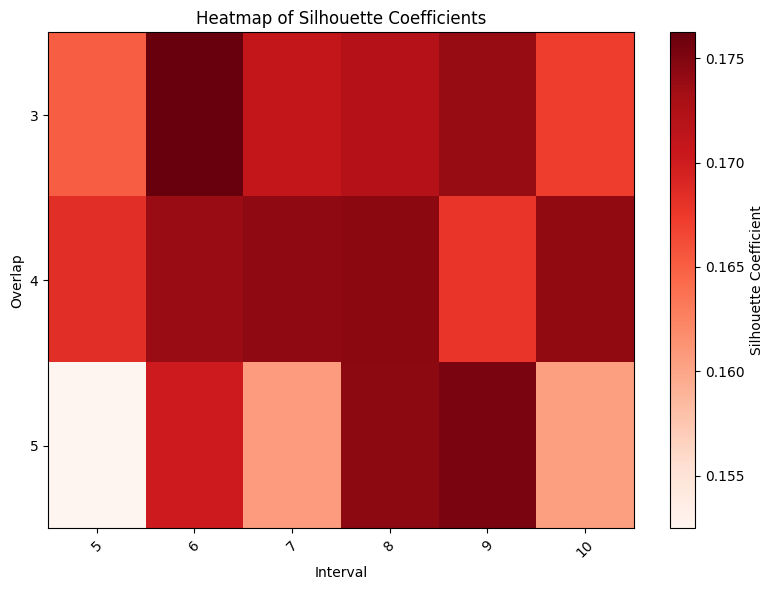

In [36]:
matrix = detailed_results_df.pivot_table(index="overlap", columns="interval", values="silhouette")

plt.figure(figsize=(8, 6))
plt.imshow(matrix, cmap='Reds', aspect='auto', interpolation='nearest')
plt.colorbar(label='Silhouette Coefficient')
plt.xticks(range(len(matrix.columns)), matrix.columns, rotation=45)
plt.yticks(range(len(matrix.index)), matrix.index)
plt.xlabel('Interval')
plt.ylabel('Overlap')
plt.title('Heatmap of Silhouette Coefficients')
plt.tight_layout()
plt.show()

In [58]:
mapper_plot1 = MapperLayoutInteractive(
    detailed_results_df['mapper_info'][1][0],
    # colors = data_to_map[['號誌-號誌種類名稱_無號誌']].to_numpy(),
    colors = rbind_data['死亡'].to_numpy(),
    cmap = 'jet',
    # agg = np.nanmean,
    # agg = most_frequent_nonan,
    agg = average_encoded_label,
    dim = 3,
    iterations = 200,
    seed = 6,
    width = 800,
    height = 500)

# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

# Testing for params

### 目前最佳參數為interval=10, overlap=0.6, cluster=10 (PCA)

In [15]:
start_time = time.time()

mapper_algo1 = MapperAlgorithm(
    cover = CubicalCover(
        n_intervals = 7,
        overlap_frac = 0.4
    ),
    clustering = FailSafeClustering(
        clustering = AgglomerativeClustering(),
        verbose = True)
)

# mapper_graph1 = mapper_algo1.fit_transform(mapper_numpy, lens)
mapper_graph1 = mapper_algo1.fit_transform(mapper_numpy, lens)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

KeyboardInterrupt: 

In [10]:
mapper_plot1 = MapperLayoutInteractive(
    mapper_graph1[0],
    # colors = data_to_map[['號誌-號誌種類名稱_無號誌']].to_numpy(),
    colors=rbind_data['死亡'].to_numpy(),
    cmap = 'jet',
    # agg = np.nanmean,
    # agg = most_frequent_nonan,
    agg = average_encoded_label,
    dim = 3,
    iterations = 200,
    seed = 6,
    width = 800,
    height = 500)

In [60]:
# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

In [17]:
rbind_data.columns

Index(['道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱', '事故位置大類別名稱',
       '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱',
       '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
       '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
       '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
       '事故類型及型態子類別名稱', '死亡', '受傷'],
      dtype='object')

In [ ]:
selected_columns = data_to_map.columns[data_to_map.columns.str.contains('死亡')]
selected_columns

In [ ]:
# mapper_plot1.update(
#     colors=rbind_data['死亡'].to_numpy(),
#     cmap = 'jet', 
#     agg=average_encoded_label,
#     # agg = most_common_encoded_label
# )

# fig_std = mapper_plot1.plot()
# fig_std.show(config={'scrollZoom': True})

## Get data info

In [ ]:
x = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
z = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

import re
data_tuple = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

data = []
for item in data_tuple:
    color = int(re.search(r'color: (-?\d+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot1._MapperLayoutInteractive__graph)['_node']

mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
mp_content.reset_index(inplace=True)
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

In [ ]:
calinski_data = get_calinski_from_db(full_info, 0.006)
labels = calinski_data[3]
db = calinski_data[2]
n_clusters_ = calinski_data[4]

print(n_clusters_)

do_plot(full_info, calinski_data, labels, db, n_clusters_)

label_0 = full_info[full_info['label'] == 0]
label_1 = full_info[full_info['label'] == 1]
label_out = full_info[(full_info['label'] != 1) & (full_info['label'] != 0)]

count_0 = get_count_dict(label_0)
count_1 = get_count_dict(label_1)
count_out = get_count_dict(label_out)
full_0 = rbind_data.loc[count_0.keys()]
full_1 = rbind_data.loc[count_1.keys()]
full_out = rbind_data.loc[count_out.keys()]
# 重疊
lst01 = list(count_0.keys() & count_1.keys())
full_01 = full_0.loc[lst01]

full_0 = full_0.drop(lst01)
full_1 = full_1.drop(lst01)

# print('01連接點數量', len(lst01))

full_01.shape[0] + full_0.shape[0] + full_1.shape[0] == rbind_data.shape[0]

In [ ]:
# fig_mean1 = mapper_plot1.plot()
# fig_mean1.show(config={'scrollZoom': True})

In [ ]:
def get_specific_cluster(label):
    
    label_data = full_info[full_info['label'] == label]
    count = get_count_dict(label_data)
    full = rbind_data.loc[count.keys()]
    return full

for i in range(7):
    
    specific_data = get_specific_cluster(i)

    print(specific_data['死亡'].value_counts(normalize = True))

## Chi test

In [ ]:
# full_1#.drop(['緯度'], axis=1)

In [ ]:
result = compare_categorical_features(full_0.drop(['緯度', '經度', '速限-第1當事者'], axis=1), 
                                      full_1.drop(['緯度', '經度', '速限-第1當事者'], axis=1))
result.sort_values(by="chi2", ascending=False)

## 四分位圖

In [ ]:
# latitude_data_full_0 = full_0['經度']
# latitude_data_full_1 = full_1['經度']

# # 繪製四分位圖
# plt.figure(figsize=(10, 6))
# plt.boxplot([latitude_data_full_0, latitude_data_full_1], labels=['full_0', 'full_1'])
# plt.title('緯度的四分位圖')
# plt.ylabel('緯度')
# plt.grid(True)
# plt.show()

## 計數圖

In [ ]:
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] # Window
# plt.rcParams['font.sans-serif']=['Arial Unicode Ms'] # Mac
plt.rcParams['axes.unicode_minus'] = False

injury_distribution = pd.DataFrame({
    'full_0': full_0['號誌-號誌動作名稱'].value_counts(normalize=True),
    'full_1': full_1['號誌-號誌動作名稱'].value_counts(normalize=True)
})

print(injury_distribution)

# 可視化分布差異
injury_distribution.plot(kind='bar', figsize=(10, 6))
plt.title('distribution')
plt.xlabel('injured state')
plt.ylabel('ratio')
plt.show()

## Pickle save

In [ ]:
# import pickle

# with open('../Version3/GridSearch/全部mapper資料.pkl', 'wb') as f:
#     pickle.dump(results, f)

# Grid search

In [ ]:
n_intervals_range = range(3, 6)
overlap_frac_range = [round(0.4 + i * 0.05, 2) for i in range(5)]

print(n_intervals_range)
print(overlap_frac_range)

results = []

for n_intervals in n_intervals_range:
    for overlap_frac in overlap_frac_range:
        
        start_time = time.time()

        mapper_algo = MapperAlgorithm(
            cover=CubicalCover(
                n_intervals=n_intervals,
                overlap_frac=overlap_frac
            ),
            clustering=FailSafeClustering(
                clustering=AgglomerativeClustering(5, linkage='single'),
                verbose=False
            )
        )

        mapper_graph = mapper_algo.fit_transform(mapper_numpy, lens)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(elapsed_time)
        
        results.append({
            'n_intervals': n_intervals,
            'overlap_frac': overlap_frac,
            'graph': mapper_graph
        })
        
        print(f"Added parameters: n_intervals={n_intervals}, overlap_frac={overlap_frac}")

In [ ]:
# for idx, graph in enumerate(results):
#     mapper_plot = MapperLayoutInteractive(
#         graph['graph'],
#         colors=dummy_data[['死亡']].to_numpy(),
#         cmap='jet',
#         agg=np.nanmean,
#         dim=3,
#         iterations=30,
#         seed=6,
#         width=800,
#         height=500
#     )

#     fig = mapper_plot.plot()

#     fig.show(config={'scrollZoom': True})

#     fig.write_html(f"mapper_plot_{idx}.html")

# Example parameters

1. 以圖像為例，較高的interval(10)配上較高的overlap(0.65)有較直觀的效果，而使用clustering方法設為10的華德法也較好，同時範例將PCA設為2。[連結](https://pypi.org/project/tda-mapper/0.2.0/)
2. 但是將PCA調高雖然增加計算量，但是也在interval不設置大麼多的情況下得到好的結果
3. 設置高的clsustering數量可以得出較好的捕捉局部資料lens = PCA(2).fit_transform(X)

In [ ]:
from sklearn.datasets import load_digits

X, y = load_digits(return_X_y=True) 

pca = PCA(n_components=2)
lens = pca.fit_transform(X)

explained_variance_ratio  = pca.explained_variance_ratio_
print(sum(explained_variance_ratio))
print(explained_variance_ratio)

In [ ]:
# mapper_algo = MapperAlgorithm(
#     cover=CubicalCover(
#         n_intervals=10,
#         overlap_frac=0.65),
#     clustering = FailSafeClustering(
#         clustering = AgglomerativeClustering(10, linkage='ward'),
#         verbose = False)
# )
# mapper_graph = mapper_algo.fit_transform(X, lens)

# mapper_plot = MapperLayoutInteractive(
#     mapper_graph,
#     colors=y,                       
#     cmap='jet',
#     agg=np.nanmean,
#     dim=3,
#     iterations=400,
#     seed=42,
#     title='digit (mean)',
#     width=600,
#     height=600)

# fig_mean1 = mapper_plot.plot()
# fig_mean1.show(config={'scrollZoom': True})